In [1]:
import re,glob,os,json,copy
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec

from scipy.stats import gaussian_kde

import baltic as bt

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])


Tree height: 74.358012
Tree length: 253.461762
multitype tree
annotations present

Numbers of objects in tree: 107 (62 nodes and 45 leaves)

genome
hypothetical3
gp64
hypothetical
hypothetical2
PB1
PB2
PA
NP
seg0 NP
seg1 PA
seg2 PB1
seg3 PB2
seg4 gp64
seg5 hypothetical2
seg6 hypothetical3
seg7 hypothetical


/Users/evogytis/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


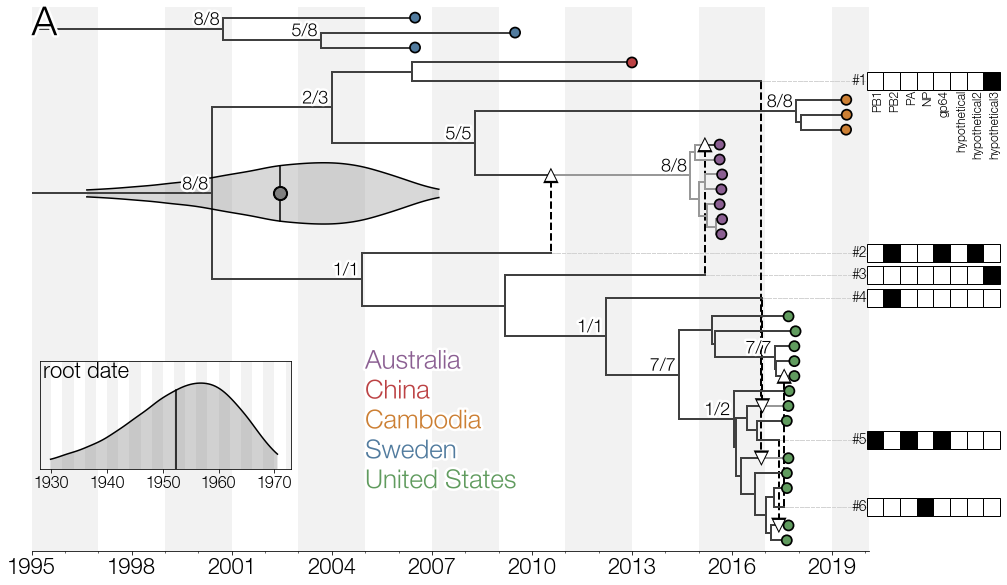

In [2]:

def plotNetwork(ax,ll):
    """
    Plots the reassortment network given a matplotlib axes and baltic tree (network)
    """
    posteriorCutoff=lambda k: k.traits['posterior']>=0.1 and k.length>0.0 ## define cutoff for removing reassortment events

    keep=set(list(filter(posteriorCutoff,ll.getBranches(lambda k: k.is_leaflike() and k.is_leaf()==False)))+ll.getExternal(lambda k: k.is_leaf())) ## remove reassortment at a given cutoff

    ll=ll.reduceTree(keep) ## reduce tree down to those that pass posterior cutoff

    for k in ll.Objects: ## add a reassortment counter to each branch (will be used for colouring clades)
        k.traits['re']=0

    for k in sorted(ll.Objects,key=lambda w: w.height): ## iterate through branches, starting with oldest ones
        if hasattr(k,'contribution'): ## if branch is the result of reassortment
            subtree=ll.traverse_tree(k.children[-1],include_condition=lambda w:True) ## traverse the subtree, remembering every branch visited along the way
            for w in subtree: ## for every branch in subtree
                if posteriorCutoff(k.contribution): ## if it's a branch that passes a posterior threshold
                    w.traits['re']=max([w.traits['re']+1,k.contribution.traits['re']+1]) ## increment on maximum reassortment number up to this point (increment either parent's or contribution's statistic)
    
    tree_names=['PB1','PB2','PA','NP','gp64','hypothetical','hypothetical2','hypothetical3'] ## desired segment order
    xml_segment_order=['NP', 'PA', 'PB1', 'PB2', 'gp64', 'hypothetical2', 'hypothetical3', 'hypothetical'] ## order in which segments appear in XML
    
    #######
    seg_trees={}
    for seg in glob.glob(os.path.join('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/data/Fig1/*.mcc.tree')): ## iterate over segment embedding trees (MCC summaries of purely clonal individual segment trees)

        seg_name=os.path.basename(seg).split('.')[0]
        print(seg_name)

        seg_tree=bt.loadNexus(seg)
        seg_tree.traverse_tree()

        seg_trees[seg_name]=seg_tree
    #######

    node_supports={}

    for t in ['seg%d'%(i) for i in range(8)]: ## iterate over segment embeddings 
        clonal_tree=seg_trees[xml_segment_order[int(t[-1])]] ## get corresponding embedding
        
        R=copy.deepcopy(ll) ## deepcopy network
        ret_edge_descendants=[k for k in R.Objects if isinstance(k,bt.reticulation) and k.traits[t]=='true'] ## get reticulations carrying segment of interest

        for k in sorted(ret_edge_descendants,key=lambda o: (-o.height,1 if o.target.is_leaf() else len(o.target.leaves))): ## iterate over reticulations
            downstream=k.target ## get descendants of reticulation
            former_upstream=downstream.parent ## old parent of reticulation descendants (major parent)
            upstream=k.parent ## get parents of reticulation


            downstream.length=downstream.height-k.height+k.length ## adjust branch length

            upstream.children.append(downstream) ## add reticulation descendant to minor parent

            former_upstream.children.remove(downstream) ## remove reticulation descendant from major parent

            upstream.children.remove(k) ## remove reticulation from its parent
            downstream.parent=upstream ## new parent of reticulation descendant is reticulation's parent

        R.fixHangingNodes() ## fix nodes without descendants
        R.traverse_tree() ## fix heights

        R=R.reduceTree(R.getExternal(lambda w: '#' not in w.name)) ## remove reticulation tips
        R.singleType() ## remove multitype branches

        print(t,xml_segment_order[int(t[-1])])

        for k in clonal_tree.getInternal(): ## nodes of segment embedding
            for w in R.getInternal(): ## nodes of adjusted network
                if len(k.leaves.intersection(w.leaves))==len(k.leaves)==len(w.leaves): ## complete overlap in descendants     
                    if w.index not in node_supports: node_supports[w.index]={} ## remember node index
                    node_supports[w.index]['%s_support'%(t)]=k.traits['posterior'] ## assign segment embedding posterior support to network node

    for w in ll.getInternal(lambda q: q.length>1.0): ## iterate over internal nodes of network
        if w.index in node_supports: ## internal node has been assigned support from clonal embedding

            total=len(node_supports[w.index]) ## get number of times node was present in clonal embeddings
            good=len([q for q in node_supports[w.index] if node_supports[w.index][q]>=0.95]) ## count how many have posterior probability >0.95

            effects=[path_effects.Stroke(linewidth=5, foreground='w'),
                     path_effects.Stroke(linewidth=0.0, foreground='k')]

            ax.text(w.absoluteTime-0.1,w.y,'%s/%s'%(good,total),color='k',size=18,ha='right',va='bottom',path_effects=effects,zorder=100) ## add text to node to indicate it's well-supported
    
    tip_colours={'CHN': '#bc4244', 
                 'SWE-Kristianstad': '#517b9e', 
                 'SWE-Dalalven': '#517b9e', 
                 'USA-CA': '#609b5e', 
                 'USA-NJ': '#5e9b9b', 
                 'AUS': '#8b5f92', 
                 'KHM': '#cc7f33', 
                 'GRC': '#77BEDB',
                 'PRI': '#A5CCB2'} ## tip colours

    ll.mostRecent=max([k.absoluteTime for k in ll.getExternal()]) ## get most recent tip date

    x_attr=lambda k: k.absoluteTime
    colour=lambda k: tip_colours[k.name.split('|')[2]]

    colour_cycle=['#404040','#989898'] ## shades of grey/black that will be alternating with every reassortment event
    ll.plotTree(ax,target=lambda k: k not in ll.root.children,x_attr=x_attr,colour=lambda w: colour_cycle[w.traits['re']%len(colour_cycle)]) ## plot all branches that aren't at the root, colour according to number of reassortments
    
    ll.plotTree(ax,target=lambda k: k in ll.root.children,x_attr=x_attr,ls='--') ## plot root branches with dotted lines

    ll.plotPoints(ax,target=lambda k: k.is_leaf(),size=70,x_attr=x_attr,colour=colour) ## plot tip circles
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))

    
    for i,k in enumerate(sorted(ll.getBranches(lambda w: w.is_leaflike() and w.is_leaf()==False and posteriorCutoff(w)),key=lambda q: -q.y)): ## iterate over reassortment edges, in y-axis order
        segs=sorted(map(int,k.traits['segments'])) ## get travelling segment(s)
        c='k'
        size=120
        xp=k.parent.absoluteTime
        x=k.absoluteTime
        y=k.y

        w=0.5
        h=w*2.4
        
        for s in range(len(tree_names)): ## iterate over segments
            if s in segs:
                fc='k' ## segment travelled, rectangle is black
            else:
                fc='w' ## segment didn't travel, rectangle is white
            seg=xml_segment_order[s]
            base=ll.mostRecent+0.6

            rect=plt.Rectangle((base+tree_names.index(seg)*w,y-h/2),w,h,facecolor=fc,edgecolor='k',lw=1,clip_on=False) ## add rectangle to indicate whether the segment travelled or not

            if i==0: ## starting at topmost reassortant edge
                ax.text(base+s*w+w,y-h/2,tree_names[s],size=12,rotation=90,ha='right',va='top') ## add segment label

            ax.plot([x,base],[y,y],ls='--',lw=1,color='lightgrey',zorder=0) ## connect reassortant edge to its summary rectangles
            ax.add_patch(rect)

        ax.text(base,y,'#%d'%(i+1),ha='right',va='center',size=14) ## count reassortant edge

        ax.plot([xp,x,x],[y,y,k.target.y],color=c,lw=2,ls='--',zorder=1) ## plot vertical lineage leaving donor and heading to recipient

        if k.target.y>k.y: ## add a triangle indicating direction
            marker='^'
        elif k.target.y<k.y:
            marker='v'

        ax.scatter(x,k.target.y,s=size,marker=marker,facecolor='w',edgecolor='none',zorder=300) ## plot circles
        ax.scatter(x,k.target.y,s=size*2,marker=marker,facecolor='k',edgecolor='none',zorder=299)

    ########
    for line in open('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/data/Fig1/genome.network.tmrcas.txt','r'): ## fetch TMRCA estimates
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header={x:i for i,x in enumerate(l)}
            tmrcas={x: [] for x in header}
        else:
            for x in header:
                if l[header[x]]!='None':
                    tmrcas[x].append(float(l[header[x]]))

    focal_node=ll.commonAncestor([k for k in ll.getExternal(lambda w: w.is_leaf()) if 'SWE' not in k.name],strict=True) ## get common ancestor of non-Swedish samples
    data=tmrcas['nonSwedish']

    kde=gaussian_kde(data) ## estimate KDE
    hpdLo,hpdHi=hpd(data,0.95)
    x_grid=np.linspace(hpdLo,hpdHi,100)
    scale=13
    y_up=[focal_node.y+y*scale for y in kde(x_grid)]
    y_lo=[focal_node.y-y*scale for y in kde(x_grid)]

    ax.plot(x_grid,y_lo,color='k') ## plot TMRCA 95% HPD
    ax.plot(x_grid,y_up,color='k')
    ax.fill_between(x_grid,y_lo,y_up,facecolor='grey',alpha=0.3)
    
    mu=np.mean(data) ## indicate mean
    ax.plot([mu,mu],[focal_node.y+kde(mu)*scale,focal_node.y-kde(mu)*scale],ls='-',color='k')
    ax.scatter(mu,focal_node.y,s=100,facecolor='grey',zorder=3)
    ax.scatter(mu,focal_node.y,s=200,facecolor='k',zorder=2)
    
    countries={'KHM': 'Cambodia', 'USA-CA': 'United States', 'SWE-Kristianstad': 'Sweden', 
               'CHN': 'China', 'AUS': 'Australia'} ## decode countries for legend

    for c,C in enumerate(sorted(countries)): ## add legend
        fc=tip_colours[C] if C in tip_colours else (tip_colours[C.split('-')[0]] if C.split('-')[0] in tip_colours else 'grey')
        effects=[path_effects.Stroke(linewidth=5, foreground='w'),
                     path_effects.Stroke(linewidth=0.0, foreground=fc)]
        ax.text(2005,12-c*2,countries[C],size=26,color=fc,path_effects=effects)
    

    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y',size=0)
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(3))
    [ax.axvspan(t,t+2,facecolor='k',edgecolor='none',alpha=0.05,zorder=0) for t in range(1955,2020,4)]

    effects=[path_effects.Stroke(linewidth=5, foreground='w'),
                     path_effects.Stroke(linewidth=0.0, foreground='k')]
    ax.text(0.0,1.0,'A',size=40,ha='left',va='top',transform=ax.transAxes,path_effects=effects)

    ##############
    axins = ax.inset_axes([0.01, 0.15, 0.3, 0.2]) ## inset axes for root TMRCA

    node=ll.root
    data=tmrcas['root'] ## get root TMRCA posterior
    kde=gaussian_kde(data)
    hpdLo,hpdHi=hpd(data,0.95)
    x_grid=np.linspace(hpdLo,hpdHi,100)
    y_grid=kde(x_grid)
    
    
    axins.plot(x_grid,y_grid,color='k') ## plot root TMRCA
    axins.fill_between(x_grid,y_grid,facecolor='dimgrey',alpha=0.3)
    mu=np.mean(data)
    axins.plot([mu,mu],[0,kde(mu)],color='k')
    
    axins.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    [axins.axvspan(t,t+2,facecolor='k',edgecolor='none',alpha=0.05,zorder=0) for t in range(1920,2020,4)]
    
    axins.set_yticks([])
    axins.set_yticklabels([])
    axins.tick_params(labelsize=16)
    axins.text(0.01,0.99,'root date',size=22,va='top',ha='left',transform=axins.transAxes)
    
    axins.set_xlim(1928,1973)
    axins.set_ylim(0,0.05)
    
    ax.set_xlim(1995,2020.1)
    ax.set_ylim(-0.2,ll.ySpan+0.2)
    
    return ax


fig = plt.figure(figsize=(15, 10),facecolor='w')
gs = GridSpec(1,1,wspace=0.01,hspace=0.1) 

ax=plt.subplot(gs[0],facecolor='w')

ll=bt.loadNexus('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/data/Fig1/genome.network.combined.mcc.tree')
ll.treeStats()

plotNetwork(ax,ll)

plt.show()

In [3]:
def polar_transform(ax,tree,circStart=0.0,circFrac=1.0,inwardSpace=0.0,precision=20):
    """
    Given axes and a baltic tree object plot a circular tree.
    """
    x_attr=lambda k:k.x
    y_attr=lambda k:k.y
    colour='k'
    width=2
    
    if inwardSpace<0: inwardSpace-=tree.treeHeight ## if inward space is negative then tree is pointing inwards
    
    branches=[] ## will hold branch coordinates
    cs=[] ## will hold colours
    linewidths=[] ## will hold branch widths
    
    circ_s=circStart*np.pi*2 ## where circle starts
    circ=circFrac*np.pi*2 ## how long the circle is (2pi=full)

    allXs=list(map(x_attr,tree.Objects)) ## get all branch heights
    allXs.append(max(allXs)*1.1) ## add a guaranteed maximum height that's 10% bigger
    normaliseHeight=lambda value: (value-min(allXs))/(max(allXs)-min(allXs)) ## create normalisation function for height
    linspace=lambda start,stop,n: list(start+((stop-start)/(n-1))*i for i in range(n)) if n>1 else stop ## hacky linearly spaced list of floats function
    
    done=[] ## remember which coordinates were done on the map
    S=0.07
    step=0.01
    
    y0=circ_s-0.34 ## where scale bar will begin - where tree starts, but pulled back a bit
    x0=normaliseHeight(0+inwardSpace) ## scale bar starts at 0 (+offset)
    x1=normaliseHeight(S+inwardSpace) ## scale bar finishes at 10 (+offset)
    
    ### scale bar main line
    ax.plot([np.sin(y0)*x0,np.sin(y0)*x1],[np.cos(y0)*x0,np.cos(y0)*x1],color='k',lw=1)
    
    #### scale bar ticks
    for i in np.arange(0,S,step):
        w=0.04+i*0.0005 ## tick size increases towards centre
        y_line=np.linspace(y0,y0+w,10) ## 10 segments to curve the ticks slightly, size alternates between odd and even
        
        x=normaliseHeight(i+inwardSpace) ## tick position
        ax.plot(np.sin(y_line)*x,np.cos(y_line)*x,color='k',lw=1) ## plot tick
        
        ax.plot(np.sin(np.linspace(y0,y0+circ+(circ_s-y0),100))*x,np.cos(np.linspace(y0,y0+circ+(circ_s-y0),100))*x,color='lightgrey',ls='--',alpha=0.6,lw=1,zorder=0) ## plot faint full circle for labelled ticks
        
        ax.text(np.sin(y_line[-1]+w*0.4)*x,np.cos(y_line[-1]+w*0.4)*x,'%.2f'%(i),ha='right',va='center',size=14,rotation=-np.rad2deg(y_line[-1])+180,rotation_mode='anchor') ## add tick label
    
    #### scale bar label
    ax.text(np.sin(y0-0.06)*np.mean([x0,x1]),np.cos(y0-0.06)*np.mean([x0,x1]),'PB1 subs/site',size=14,ha='center',va='top',rotation=-np.rad2deg(y0)-90,rotation_mode='anchor')
    
    ################
    
    for k in tree.Objects: ## iterate over branches
        x=normaliseHeight(x_attr(k)+inwardSpace) ## get branch x position
        xp=normaliseHeight(x_attr(k.parent)+inwardSpace) if k.parent.parent else x ## get parent x position
        y=y_attr(k) ## get y position
        
        try: ## try getting colour
            cs.append(colour(k)) if callable(colour) else cs.append(colour)
        except KeyError: ## grey if failed
            cs.append((0.7,0.7,0.7))
        linewidths.append(width(k)) if callable (width) else linewidths.append(width) ## add branch width

        y=circ_s+circ*y/tree.ySpan ## convert y coordinate
        X=np.sin(y) ## polar transform
        Y=np.cos(y) ## polar transform
        branches.append(((X*xp,Y*xp),(X*x,Y*x))) ## add branch segment
        
        if k.is_node(): ## internal node
            yl,yr=y_attr(k.children[0]),y_attr(k.children[-1]) ## get leftmost and rightmost children's y coordinates
            yl=circ_s+circ*yl/tree.ySpan ## transform y into a fraction of total y for left child
            yr=circ_s+circ*yr/tree.ySpan ## same for right child
            ybar=linspace(yl,yr,precision) ## what used to be vertical node bar is now a curved line

            xs=[yx*x for yx in np.sin(ybar)] ## convert to polar coordinates
            ys=[yy*x for yy in np.cos(ybar)] ## convert to polar coordinates

            branches+=tuple(zip(zip(xs,ys),zip(xs[1:],ys[1:]))) ## add curved segment
            
            linewidths+=[linewidths[-1] for q in zip(ys,ys[1:])] ## repeat linewidths
            cs+=[cs[-1] for q in zip(ys,ys[1:])] ## repeat colours
        else: ## external node/tip
            strain=k.name.split('|')[1]
            
            s=65 ## size of marker
            ec='k' ## get edge colour for tip
            scale=1.8 ## set edge line size
            al=1.0
            lw=2
            ls=':'
            z=10000
            
            treeEnd=normaliseHeight(ll.treeHeight*0.90+inwardSpace) ## coordinate that sticks out a bit past the tree's highest point
            
            fc=tip_colours[k.name.split('|')[2]]
            
            ax.scatter(X*x,Y*x,s=s,facecolor=fc,edgecolor='none',zorder=z) ## plot main marker
            ax.scatter(X*x,Y*x,s=s*1.8,facecolor=ec,edgecolor='none',zorder=z-1) ## plot main marker
            
    line_segments = LineCollection(branches,lw=linewidths,ls='-',color=cs,capstyle='projecting',zorder=2) ## create line segments that will be tree branches
    ax.add_collection(line_segments) ## add collection to axes
    
    line_segments = LineCollection(branches,lw=[lw*3 for lw in linewidths],ls='-',color=['w' for c in cs],capstyle='projecting',zorder=1) ## create line segments that will be a white outline to tree branches
    ax.add_collection(line_segments) ## add collection to axes
    
    ax.add_patch(plt.Circle((0.0,0.0),1.0,facecolor='w',edgecolor='none',zorder=0)) ## add white background circle


((('SwedenL7|Culex_pipiens|SWE-Kristianstad|2007-07-01':0.008146,'SwedenL6|Culex_pipiens|SWE-Kristianstad|2006-07-01':0.002472):0.002736,('SwedenL8|Culex_pipiens|SWE-Dalalven|2009-07-01':0.005931,'SwedenL5|Culex_pipiens|SWE-Dalalven|2006-07-01':0.001786):0.001989):0.045355,(('Cxp_June_NX|Culex_pipiens|CHN|2019-06-15':0.007159,((('CMS001_028|Culex_tarsalis|USA-CA|2017-09-12':0.004652,(('CMS002_056a|Culex_tarsalis|USA-CA|2017-11-28':0.001680,('CMS002_029c|Culex_tarsalis|USA-CA|2017-11-15':0.000000,('CMS002_029d|Culex_tarsalis|USA-CA|2017-11-15':0.000837,'CMS002_029e|Culex_tarsalis|USA-CA|2017-11-15':0.000836):0.000000):0.001678):0.000000,(('CMS001_042|Culex_tarsalis|USA-CA|2017-08-25':0.001680,('CMS001_039|Culex_tarsalis|USA-CA|2017-08-24':0.000839,'CMS001_043|Culex_tarsalis|USA-CA|2017-08-25':0.000418):0.000839):0.000841,('CMS001_032|Culex_tarsalis|USA-CA|2017-09-12':0.000836,('CMS001_038|Culex_tarsalis|USA-CA|2017-08-24':0.000836,('CMS001_002|Culex_tarsalis|USA-CA|2017-09-21':0.000837,

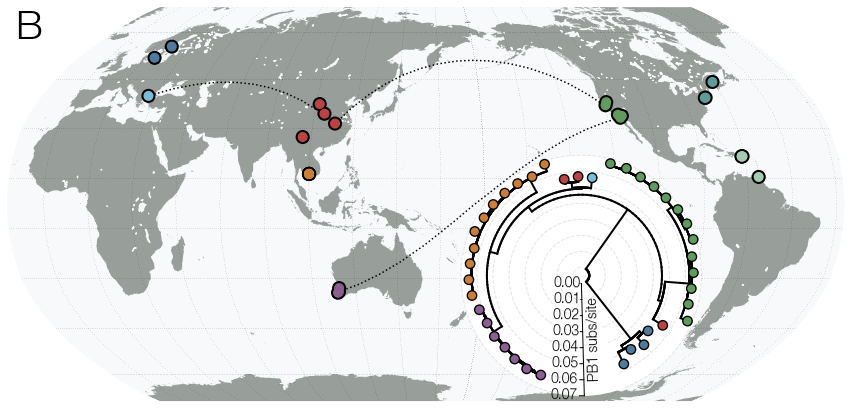

In [4]:
from matplotlib.collections import LineCollection
import baltic as bt

import cartopy
import cartopy.crs as ccrs

tip_colours={'CHN': '#bc4244', 
             'SWE-Kristianstad': '#517b9e', 
             'SWE-Dalalven': '#517b9e', 
             'USA-CA': '#609b5e', 
             'USA-NJ': '#5e9b9b', 
             'AUS': '#8b5f92', 
             'KHM': '#cc7f33', 
             'GRC': '#77BEDB',
             'PRI': '#A5CCB2',
             'TTO': '#A5CCB2'}

sampling_locations={'USA-CA': [(37.55697,-122.07938),(32.7962659,-116.9594824),(33.954615,-117.693828),(33.516797,-116.082468),(38.739939,-121.305636)], 
                    'USA-NJ': [(40.4417743,-74.1298643),(46.498390,-66.159668),(40.3806901,-74.5316938)], 
                    'CHN': [(30.592800, 114.305500),(34.341568,108.940178),(37.987057, 106.030434),(25.483,100.583)], 
                    'AUS': [(-33.305752, 115.697355),(-33.653504, 115.224000),(-31.905945, 115.973327)], 
                    'KHM': [(11.472294,104.543647), (11.470297,104.534118), (11.470745,104.528648), (11.46812,104.536349), (11.465822,104.529616)], 
                    'SWE-Dalalven': [(60.641667, 17.450000)], 
                    'SWE-Kristianstad': [(56.029400, 14.156700)], 
                    'GRC': [(41.129500, 24.887700)], 
                    'PRI': [(18.201300, -67.145200),(18.050000, -67.059300),(18.080700, -67.041100),(18.162778, -66.722222)], 
                    'TTO': [(10.3190467,-61.1301249)]}


def geoDistribution(ax,ll):
    """
    Plot map of the world
    """
    ax.set_aspect(1)
    
    ############
    scale=2
    w=0.4

    ## map scale and colour
    scale='50m'
    water='#f7f9fa'
    land='#989e99'

    ## add water bodies, continents
    ax.add_feature(cartopy.feature.LAKES.with_scale(scale),facecolor=water)
    ax.add_feature(cartopy.feature.OCEAN.with_scale(scale),facecolor=water,edgecolor=water)
    ax.add_feature(cartopy.feature.LAND.with_scale(scale),facecolor=land,edgecolor='none')

    for loc in sampling_locations: ## plot sampling locations
        for coord in sampling_locations[loc]:
            lat,lon=coord
            s=100
            fc=tip_colours[loc]
            ax.scatter(lon,lat,s=s,facecolor=fc,edgecolor='none', ## plot outline circles on map
                                       zorder=9999,transform=ccrs.PlateCarree(),clip_on=False)
            ax.scatter(lon,lat,s=s*2,facecolor='k',edgecolor='none', ## plot outline circles on map
                                       zorder=9998,transform=ccrs.PlateCarree(),clip_on=False)

    #####
    ori_lat,ori_lon=sampling_locations['AUS'][0]
    des_lat,des_lon=sampling_locations['USA-CA'][1]
    
    ax.plot([ori_lon,174.7,des_lon],[ori_lat,-1.0,des_lat],transform=ccrs.Geodetic(),ls=':',color='k',zorder=100) ## connect Australia and California

    ori_lat,ori_lon=sampling_locations['CHN'][0]
    des_lat,des_lon=sampling_locations['USA-CA'][1]
    ax.plot([ori_lon,178.2,des_lon],[ori_lat,55.03,des_lat],transform=ccrs.Geodetic(),ls=':',color='k',zorder=100) ## connect China and California

    ori_lat,ori_lon=sampling_locations['CHN'][0]
    des_lat,des_lon=sampling_locations['GRC'][0]
    ax.plot([ori_lon,des_lon],[ori_lat,des_lat],transform=ccrs.Geodetic(),ls=':',color='k',zorder=100) ## connect China and Greece

    #####

    n=400
    points=[]
    b=-180
    lons = np.linspace(b, b+360, n)

    ## default was 35
    latgrid = np.linspace(-180, 180, 20)

    for lat in latgrid:
        for lon in lons:
            points += [(lon, lat)]

    b=-180
    lats = np.linspace(b, b+360, n)
    ## default was 72
    longrid = np.linspace(-180, 180, 20)

    for lon in longrid:
        for lat in lats:
            points += [(lon,lat)] ## build grid

    points = np.array(points)
    ax.plot(points[:, 1], points[:, 0], ',', c='k', alpha=0.1,zorder=0,transform=ccrs.PlateCarree()) ## plot coordinate grid


    w=17000000        
    ax.set_xlim(-w,w)

    h=8000000
    ax.set_ylim(-h,h)

    [ax.spines[loc].set_visible(False) for loc in ax.spines]

    ax.text(0.01,0.99,'B',size=40,ha='left',va='top',transform=ax.transAxes)
    
    ###########
    # w=0.6
    h=0.245
    w=0.245

    ax2=fig.add_axes([0.534, 0.132, w, h],facecolor='none',zorder=1000) ## add sub-axes
    
    ax2.set_aspect(1)
    polar_transform(ax2,ll,circFrac=0.89,circStart=0.55,inwardSpace=0.005,precision=50) ## add tree

    [ax2.spines[loc].set_visible(False) for loc in ax2.spines] ## no spines for the plot
    ax2.set_xticks([])
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    
    return ax

fig,ax = plt.subplots(figsize=(15,17),facecolor='w')
gs = GridSpec(2,1,hspace=0.01,wspace=0.0)

ortho=ccrs.Robinson(central_longitude=155) ## projection 
ax=plt.subplot(gs[1],projection=ortho,zorder=1000,facecolor='none')

ll=bt.loadNewick('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/data/SFig3/PB1.newick')
ll=ll.reduceTree([k for k in ll.getExternal() if k.is_leaf() and 'NJ' not in k.name]) ## remove sequences that aren't public yet
ll.sortBranches(descending=True)

print(ll.toString())

node=ll.getInternal(lambda k: len(k.leaves.intersection(set(['RR031V_019|Culex_quinquefasciatus|KHM|2019-06-10', 'RR0V31_013|Culex_quinquefasciatus|KHM|2019-06-04', 'RR031V_015|Culex_quinquefasciatus|KHM|2019-06-05', 'RR0V31_001|Culex_quinquefasciatus|KHM|2019-06-04', 'RR031V_003|Culex_quinquefasciatus|KHM|2019-06-05', 'mosWSX22048|Culex_australicus|AUS|2015-08-19', 'RR031V_011|Culex_quinquefasciatus|KHM|2019-06-10', 'RR031V_006|Culex_quinquefasciatus|KHM|2019-06-06', 'RR031V_008|Culex_quinquefasciatus|KHM|2019-06-07', 'mosWSB62413|Culex_quinquefasciatus|AUS|2015-08-19', 'mos191X19029|Culex_australicus|AUS|2015-09-15', 'RR031V_009|Culex_quinquefasciatus|KHM|2019-06-10', 'RR031V_022|Culex_quinquefasciatus|KHM|2019-06-11', 'RR031V_021|Culex_quinquefasciatus|KHM|2019-06-11', 'mosWSgb78233|Culex_globocoxitus|AUS|2015-08-19', 'mos172X49967|Culex_australicus|AUS|2015-09-07', 'mos191gb22262|Culex_globocoxitus|AUS|2015-09-15', 'mos172gb65361|Culex_globocoxitus|AUS|2015-09-07'])))==len(k.leaves)==18)[0] ## identify common ancestor of Cambodia & Australia clades
node.children=node.children[::-1] ## rotate node
ll.drawTree()

geoDistribution(ax,ll) ## plot away

plt.show()


Tree height: 74.358012
Tree length: 253.461762
multitype tree
annotations present

Numbers of objects in tree: 107 (62 nodes and 45 leaves)

genome
hypothetical3
gp64
hypothetical
hypothetical2
PB1
PB2
PA
NP
seg0 NP
seg1 PA
seg2 PB1
seg3 PB2
seg4 gp64
seg5 hypothetical2
seg6 hypothetical3
seg7 hypothetical


/Users/evogytis/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


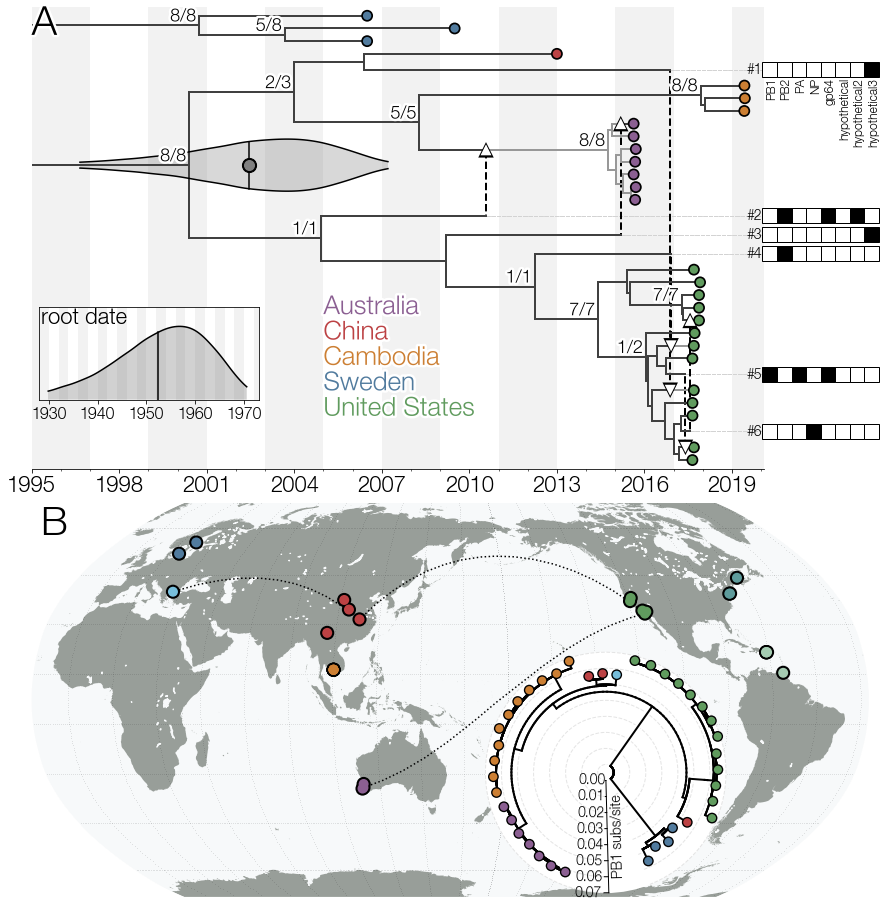

In [5]:
fig,ax = plt.subplots(figsize=(15,17),facecolor='w')

gs = GridSpec(2,2,height_ratios=[1,1],width_ratios=[7,1],hspace=0.0,wspace=0.0)
ax=plt.subplot(gs[0],zorder=1000,facecolor='none')

ll=bt.loadNexus('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/data/Fig1/genome.network.combined.mcc.tree')
ll.treeStats()

plotNetwork(ax,ll) ## plot network

ortho=ccrs.Robinson(central_longitude=155) ## projection 
ax=plt.subplot(gs[1,:],projection=ortho,zorder=1000,facecolor='none')

ll=bt.loadNewick('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/data/SFig3/PB1.newick')
ll=ll.reduceTree([k for k in ll.getExternal() if k.is_leaf() and 'NJ' not in k.name])
ll.sortBranches(descending=True)

node=ll.getInternal(lambda k: len(k.leaves.intersection(set(['RR031V_019|Culex_quinquefasciatus|KHM|2019-06-10', 'RR0V31_013|Culex_quinquefasciatus|KHM|2019-06-04', 'RR031V_015|Culex_quinquefasciatus|KHM|2019-06-05', 'RR0V31_001|Culex_quinquefasciatus|KHM|2019-06-04', 'RR031V_003|Culex_quinquefasciatus|KHM|2019-06-05', 'mosWSX22048|Culex_australicus|AUS|2015-08-19', 'RR031V_011|Culex_quinquefasciatus|KHM|2019-06-10', 'RR031V_006|Culex_quinquefasciatus|KHM|2019-06-06', 'RR031V_008|Culex_quinquefasciatus|KHM|2019-06-07', 'mosWSB62413|Culex_quinquefasciatus|AUS|2015-08-19', 'mos191X19029|Culex_australicus|AUS|2015-09-15', 'RR031V_009|Culex_quinquefasciatus|KHM|2019-06-10', 'RR031V_022|Culex_quinquefasciatus|KHM|2019-06-11', 'RR031V_021|Culex_quinquefasciatus|KHM|2019-06-11', 'mosWSgb78233|Culex_globocoxitus|AUS|2015-08-19', 'mos172X49967|Culex_australicus|AUS|2015-09-07', 'mos191gb22262|Culex_globocoxitus|AUS|2015-09-15', 'mos172gb65361|Culex_globocoxitus|AUS|2015-09-07'])))==len(k.leaves)==18)[0]
node.children=node.children[::-1]
ll.drawTree()

geoDistribution(ax,ll) ## plot map

plt.savefig('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/figures/Fig1_tracking.png',bbox_inches='tight',dpi=300)
plt.savefig('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/figures/Fig1_tracking.pdf',bbox_inches='tight',dpi=300)

plt.show()


Tree height: 74.358012
Tree length: 253.461762
multitype tree
annotations present

Numbers of objects in tree: 107 (62 nodes and 45 leaves)

genome
hypothetical3
gp64
hypothetical
hypothetical2
PB1
PB2
PA
NP


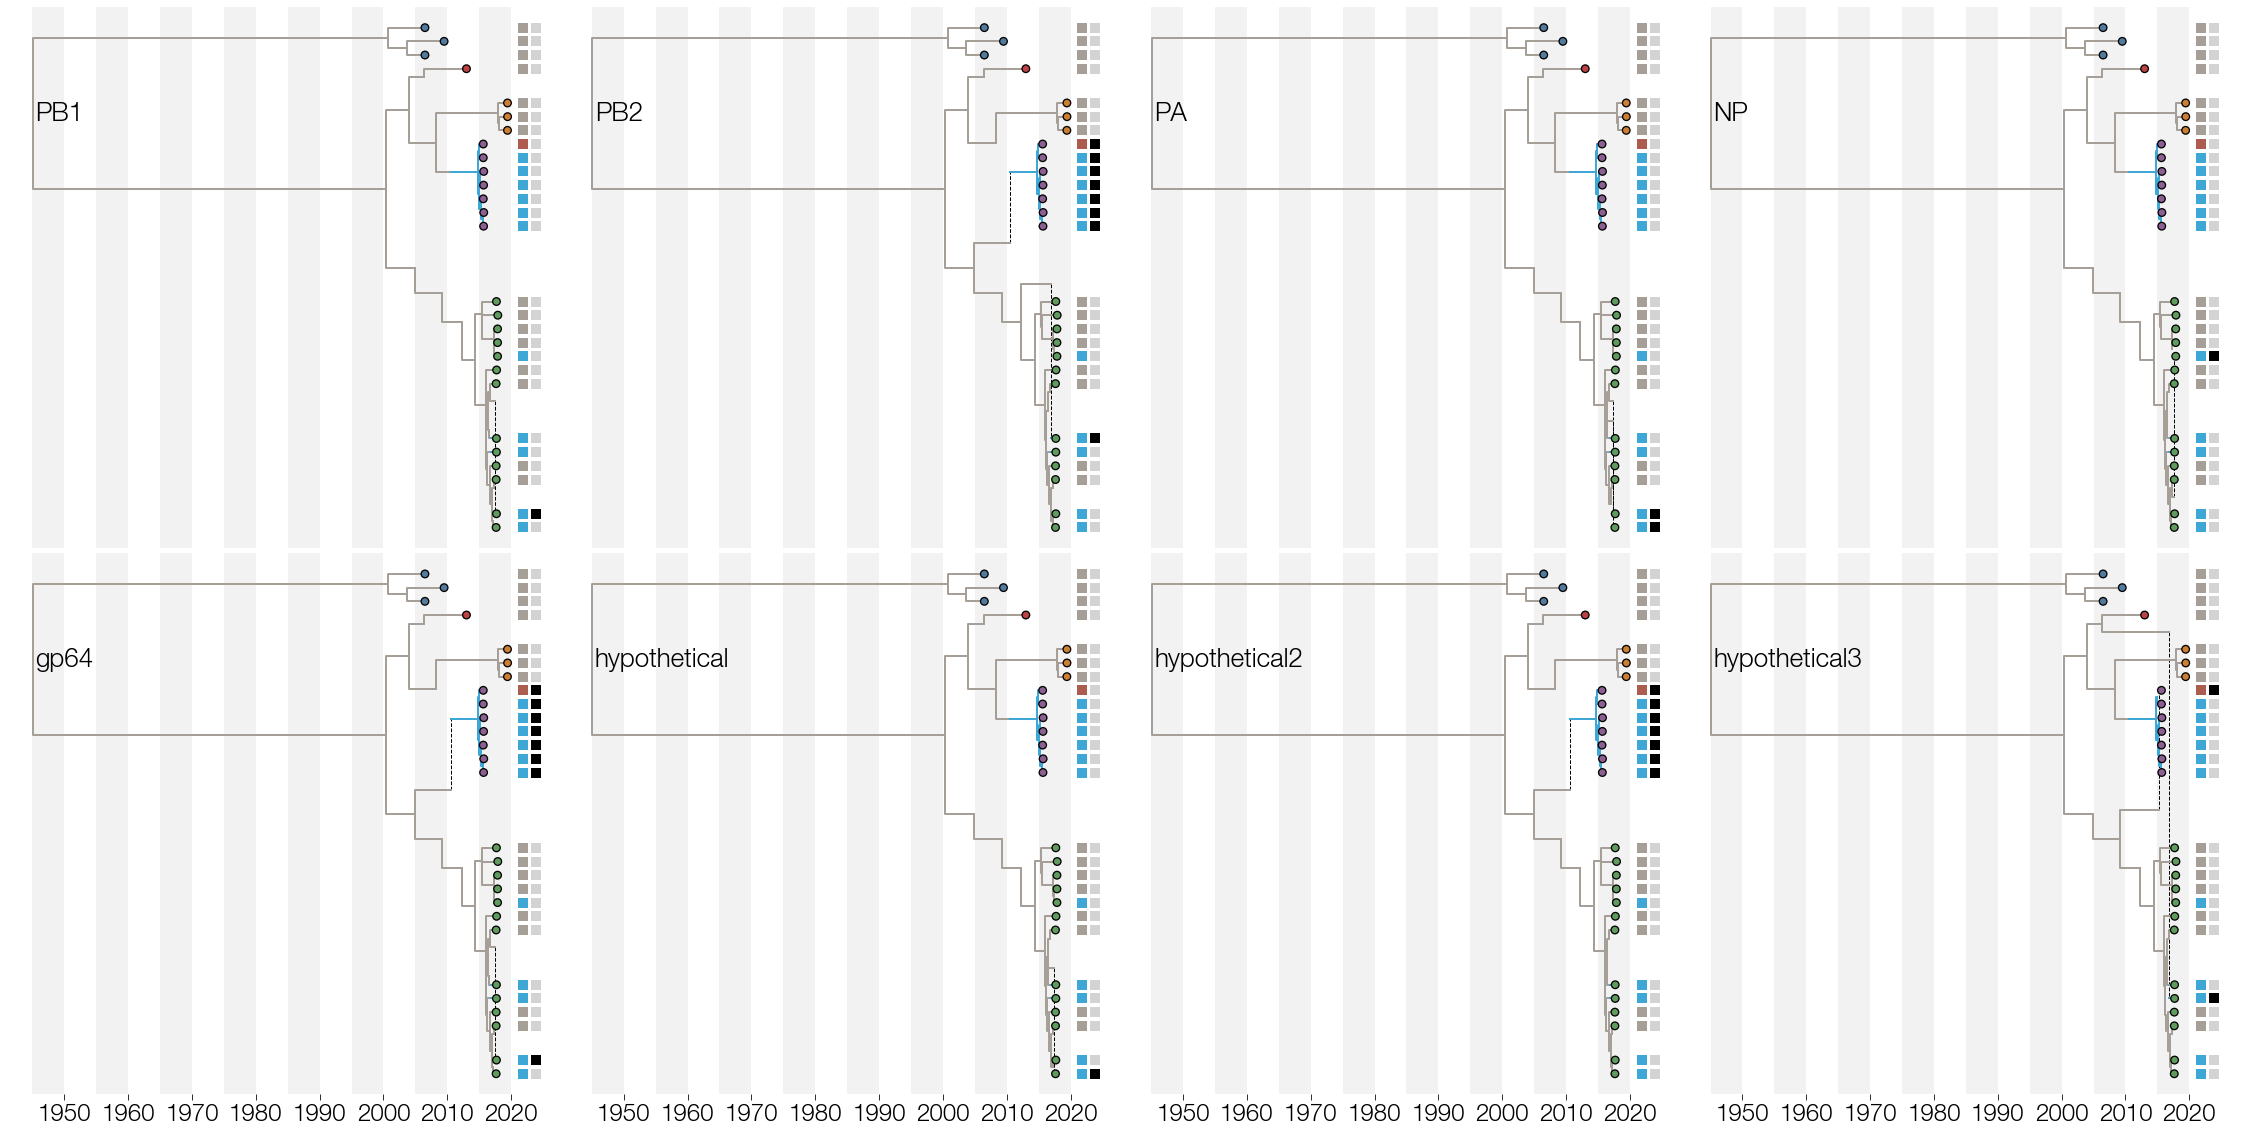

In [6]:
##### Load network
ll=bt.loadNexus('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/data/Fig1/genome.network.combined.mcc.tree')

ll.treeStats()

posteriorCutoff=lambda k: k.traits['posterior']>=0.05 and k.length>0.0 ## define cutoff for removing reassortment events
keep=set(list(filter(posteriorCutoff,ll.getBranches(lambda k: k.is_leaflike() and k.is_leaf()==False)))+ll.getExternal(lambda k: k.is_leaf())) ## remove reassortment at a given cutoff

ll=ll.reduceTree(keep) ## reduce tree down to those that pass posterior cutoff
#####

##### Load segment trees
seg_trees={}
for seg in glob.glob(os.path.join('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/data/Fig1/*.mcc.tree')):

    seg_name=os.path.basename(seg).split('.')[0]
    print(seg_name)

    seg_tree=bt.loadNexus(seg)
    seg_tree.traverse_tree()

    seg_trees[seg_name]=seg_tree

#####
    
segs=[s for s in ll.root.traits if 'seg' in s and len(s)==4]

fig = plt.subplots(figsize=(40,20),facecolor='w')

ncols=4
gs = GridSpec(len(segs)//ncols, ncols,hspace=0.01,wspace=0.01)

for k in ll.Objects:
    k.traits['re']=0

for k in sorted(ll.Objects,key=lambda w: w.height): ## iterate through branches, starting with oldest ones
    if hasattr(k,'contribution'): ## if branch is the result of reassortment
        subtree=ll.traverse_tree(k.children[-1],include_condition=lambda w:True) ## traverse the subtree, remembering every branch visited along the way
        for w in subtree: ## for every branch in subtree
            if posteriorCutoff(k.contribution): ## if it's a branch that passes a posterior threshold
                w.traits['re']=max([w.traits['re']+1,k.contribution.traits['re']+1]) ## increment on maximum reassortment number up to this point (increment either parent's or contribution's statistic)

cmap=mpl.cm.tab10_r
re_colours=['#A69F98','#3FA7D6','#AD5D4E','#FBB13C','#5CC48A']
re_stat=lambda k: k.traits['re']
cn_func=lambda k: re_colours[re_stat(k)%len(re_colours)]


tip_colours={'CHN': (0.735686274509804, 0.2603921568627451, 0.26509803921568614), 'SWE': (0.31686274509803924, 0.483921568627451, 0.6203921568627451), 'USA': (0.3764705882352942, 0.6070588235294118, 0.36941176470588244), 'AUS': (0.5466666666666669, 0.37254901960784315, 0.5725490196078431), 'KHM': (0.8, 0.4988235294117647, 0.19999999999999996)}
countries={'KHM': 'Cambodia', 'USA': 'United States', 'SWE': 'Sweden', 'CHN': 'China', 'AUS': 'Australia'}


def markBranches(tree,trait):
    """
    Descend to root through segment path, return branches comprising the path
    """
    marked=[]
    ret_edge_descendants=[k.target for k in tree.Objects if isinstance(k,bt.reticulation) and k.traits[trait]=='true'] ## find reticulate contribution receivers if they received segment
    
    for k in tree.getExternal(lambda w: w.is_leaf()): ## iterate over leaves
        cur_node=k
        
        while cur_node: ## iterate to root
            if cur_node in ret_edge_descendants: ## branch is reticulate and involved segment
                assert cur_node.contribution.traits[trait]=='true'
                cur_node=cur_node.contribution ## traverse through reticulate path
            else:
                marked.append(cur_node)
                cur_node=cur_node.parent ## traverse through clonal path
                
    return marked


def markProducts(tree,trait):
    """
    Descend to root through segment path return dict that says whether a tip is the result of reticulation.
    """
    ret_edge_descendants=[k.target for k in tree.Objects if isinstance(k,bt.reticulation) and k.traits[trait]=='true'] ## find reticulate contribution receivers if they received segment
    
    reticulate_tips={}
    
    for k in tree.getExternal(lambda w: w.is_leaf()): ## iterate over leaves
        cur_node=k
        
        while cur_node: ## iterate to root
            if cur_node in ret_edge_descendants: ## branch is reticulate and involved segment
                assert cur_node.contribution.traits[trait]=='true'
                reticulate_tips[k.name]=True
                break
            else:
                cur_node=cur_node.parent ## traverse through clonal path
        else:
            reticulate_tips[k.name]=False
                
    return reticulate_tips
    

offset=0

segment_order=['PB1','PB2','PA','NP','gp64','hypothetical','hypothetical2','hypothetical3']
xml_segment_order=['NP', 'PA', 'PB1', 'PB2', 'gp64', 'hypothetical2', 'hypothetical3', 'hypothetical'] ## order in which segments appear in XML

for s,seg in enumerate(segs):
    
    S=xml_segment_order[int(seg[-1])]
    idx=segment_order.index(S)
    ax = plt.subplot(gs[idx])
    
    x_attr=lambda k: k.absoluteTime
    marked=markBranches(ll,seg)
    ret_tips=markProducts(ll,seg)
    
    clonal=lambda k: k in marked ## want only parts that carry segments and are clonal
    ll.plotTree(ax,x_attr=x_attr,connection_type='elbow',target=clonal,colour=cn_func) ## plot clonal tree
    
    colours=lambda k: tip_colours[k.name.split('|')[2].split('-')[0]]
    ll.plotPoints(ax,x_attr=x_attr,colour=colours,size=40,target=lambda k: k.is_leaf()) ## plot tip circles

    alt_x_attr=lambda k: ll.root.absoluteTime+ll.treeHeight+4
    ll.plotPoints(ax,x_attr=alt_x_attr,colour=cn_func,outline_colour='none',marker='s',size=100,target=lambda k: k.is_leaf()) ## plot squares to indicate whether tip is descendant of reassortment
    
    alt_x_attr=lambda k: ll.root.absoluteTime+ll.treeHeight+6
    ll.plotPoints(ax,x_attr=alt_x_attr,colour=lambda w: 'k' if ret_tips[w.name] else 'lightgrey',outline_colour='none',marker='s',size=100,target=lambda k: k.is_leaf()) ## plot squares to indicate how many times the lineage leading to the tip has experienced reassortment since the root
    
    
    for reticulation in ll.getBranches(lambda k: isinstance(k,bt.reticulation)):
        if reticulation in marked:
            x=x_attr(reticulation)
            
            y=reticulation.y
            cy=reticulation.target.y
            ax.plot([x,x],[y,cy],color='k',lw=1,ls='--',zorder=1) ## plot reticulation
            
    ax.plot()
    
    segNum=int(seg[-1])+1
    seg_label='%s'%(S)
    ax.text(x_attr(ll.root)+0.4,ll.root.y,'%s'%(seg_label),size=26,va='center') ## add segment label
    ax.set_ylim(-1,ll.ySpan+1)
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    [ax.spines[loc].set_visible(False) for loc in ax.spines]

    [ax.axvspan(t,t+5,facecolor='k',edgecolor='none',alpha=0.05,zorder=0) for t in range(1945,2020,10)] ## add grey bars to timeline
    if s>3:
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
        ax.tick_params(axis='x',size=6,labelsize=24)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    
plt.savefig('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/figures/SuppFig1_clonal.png',bbox_inches='tight',dpi=300)
plt.savefig('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/figures/SuppFig1_clonal.pdf',bbox_inches='tight',dpi=300)

plt.show()

hypothetical3

Tree height: 67.960503
Tree length: 213.109402
strictly bifurcating tree
annotations present

Numbers of objects in tree: 53 (26 nodes and 27 leaves)

gp64

Tree height: 66.389704
Tree length: 200.108506
strictly bifurcating tree
annotations present

Numbers of objects in tree: 53 (26 nodes and 27 leaves)

hypothetical

Tree height: 67.268558
Tree length: 193.073743
strictly bifurcating tree
annotations present

Numbers of objects in tree: 53 (26 nodes and 27 leaves)

hypothetical2

Tree height: 67.236958
Tree length: 196.045179
strictly bifurcating tree
annotations present

Numbers of objects in tree: 53 (26 nodes and 27 leaves)

PB1

Tree height: 67.537437
Tree length: 196.662154
strictly bifurcating tree
annotations present

Numbers of objects in tree: 53 (26 nodes and 27 leaves)

PB2

Tree height: 68.865772
Tree length: 194.309715
strictly bifurcating tree
annotations present

Numbers of objects in tree: 53 (26 nodes and 27 leaves)

PA

Tree height: 66.307873
Tree le

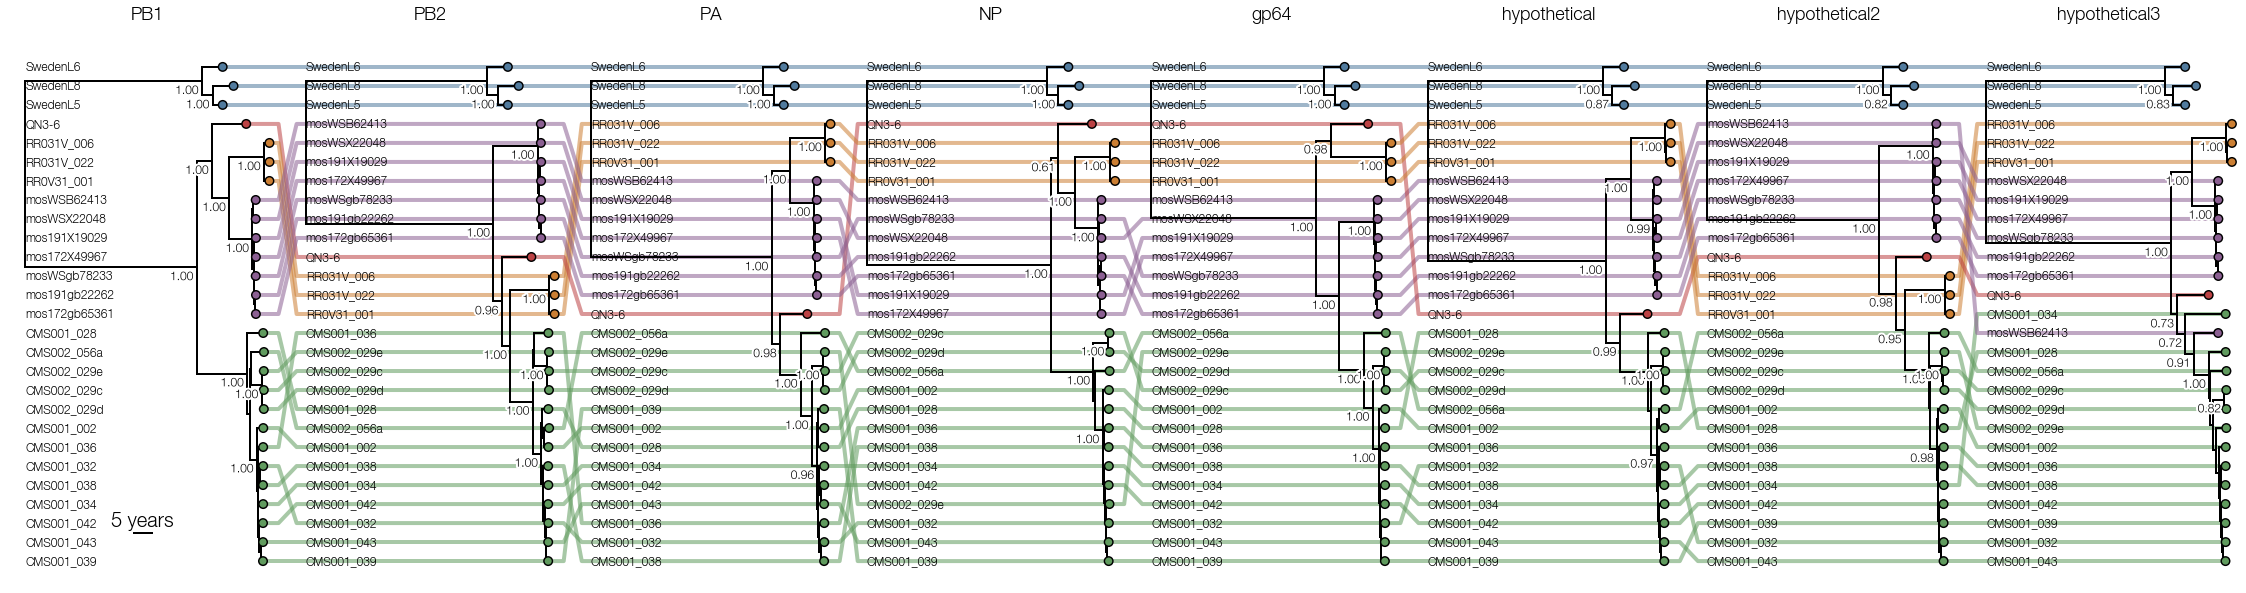

In [7]:
def subplot_tanglegram(ax):
    
    trees={}
    base_path='/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/data/Fig1'
    for tfile in glob.glob(os.path.join(base_path,'*.combined.mcc.tree')): ## load segment embedding summaries
        if 'genome' not in tfile:
            segment=os.path.basename(tfile).split('.')[0]
            print(segment)
            ll=bt.loadNexus(tfile)
            ll.treeStats()
            ll=ll.collapseBranches(lambda k: k.length==0.0)
            ll.sortBranches()
            trees[segment]=ll
    
    order=['PB1','PB2','PA','NP','gp64','hypothetical','hypothetical2','hypothetical3']

    ys={seg: {k.name: k.y for k in trees[seg].getExternal()} for seg in order}
    
    tip_colours={'CHN': '#bc4244', ## Hubei
                 'CHN-NX': '#bc4244', ## Ningxia Hui Autonomous Region
                 'CHN-SX': '#bc4244', ## Shaanxi Province
                 'SWE-Kristianstad': '#517b9e', 
                 'SWE-Dalalven': '#517b9e', 
                 'USA-CA': '#609b5e', 
                 'USA-NJ': '#5e9b9b', 
                 'AUS': '#8b5f92', 
                 'KHM': '#cc7f33', 
                 'GRC': '#77BEDB',
                 'PRI': '#A5CCB2'}
    offset=0
    space=10
    
    
    L=5
    x=30
    y=2
    ax.plot([x,x+L],[y,y],color='k',lw=2)
    ax.text(x+L/2,y+0.1,'%s years'%(L),va='bottom',ha='center',size=20)
    
    for s,seg in enumerate(order):
        ll=trees[seg]
        
        tip_colour=lambda k: tip_colours[k.name.split('|')[2]]

        tallestTree=max([trees[s].ySpan for s in trees])

        x_attr=lambda k: k.x+offset if k.parent else k.x
        y_attr=lambda k: k.y*(tallestTree/ll.ySpan)

        ll.plotTree(ax,x_attr=x_attr,y_attr=y_attr,width=2) ## plot tree
        ll.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size=50,colour=tip_colour) ## plot tips
        
        ll.addText(ax,x_attr=lambda k: offset+0.001,y_attr=y_attr,text=lambda k: k.name.split('|')[0],ha='left',va='center',size=12) ## plot tip name at tree base
        
        effects=[path_effects.Stroke(linewidth=4, foreground='w'),
                 path_effects.Stroke(linewidth=0.0, foreground='k')]
        ll.addText(ax,target=lambda k: k.is_node() and k.length>1.0,x_attr=lambda k: x_attr(k)-1.0,y_attr=lambda k: y_attr(k)-0.2,text=lambda k: '%.2f'%(k.traits['posterior']),ha='right',va='top',size=12,path_effects=effects,zorder=1000) ## add posteriors
        
        ax.text(offset+ll.treeHeight/2,tallestTree+2,seg,ha='center',size=18) ## add segment name
        if s<len(order)-1:
            for k in ll.getExternal(lambda q: q.name in [w.name for w in trees[order[s+1]].getExternal()]): ## current tree
                x1=x_attr(k)
                x2=max(map(x_attr,ll.getExternal()))+space*0.25

                counterpart=trees[order[s+1]].getBranches(lambda w: w.branchType=='leaf' and w.name==k.name)
                y1=y_attr(k)
                
                y_attr2=lambda q: q.y*(tallestTree/trees[order[s+1]].ySpan)
                y2=y_attr2(counterpart)

                x3=max(map(x_attr,ll.getExternal()))+space*0.75
                x4=max(map(x_attr,ll.getExternal()))+space+counterpart.x

                ax.plot([x1,x2,x3,x4],[y1,y1,y2,y2],color=tip_colour(k),lw=4,alpha=0.55,zorder=0) ## plot coloured line connecting same tip

        offset+=ll.treeHeight+space

    
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    ax.plot()
    
    ax.set_xlim(-space/2,offset-space*0.8)
    return ax

fig = plt.subplots(figsize=(40,10),facecolor='w')

gs = GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

subplot_tanglegram(ax)

plt.savefig('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/figures/SuppFig2_BayesTangle.png',bbox_inches='tight',dpi=300)
plt.savefig('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/figures/SuppFig2_BayesTangle.pdf',bbox_inches='tight',dpi=300)


plt.show()

PB2

Tree height: 0.090117
Tree length: 0.303155
strictly bifurcating tree

Numbers of objects in tree: 75 (37 nodes and 38 leaves)

hypothetical2

Tree height: 0.056910
Tree length: 0.172797
strictly bifurcating tree

Numbers of objects in tree: 67 (33 nodes and 34 leaves)

gp64

Tree height: 0.090194
Tree length: 0.267192
strictly bifurcating tree

Numbers of objects in tree: 65 (32 nodes and 33 leaves)

PA

Tree height: 0.087452
Tree length: 0.304176
strictly bifurcating tree

Numbers of objects in tree: 91 (45 nodes and 46 leaves)

PB1

Tree height: 0.068345
Tree length: 0.241081
strictly bifurcating tree

Numbers of objects in tree: 85 (42 nodes and 43 leaves)

hypothetical3

Tree height: 0.101216
Tree length: 0.293617
strictly bifurcating tree

Numbers of objects in tree: 83 (41 nodes and 42 leaves)

hypothetical

Tree height: 0.041624
Tree length: 0.126907
strictly bifurcating tree

Numbers of objects in tree: 91 (45 nodes and 46 leaves)

NP

Tree height: 0.070779
Tree length: 0

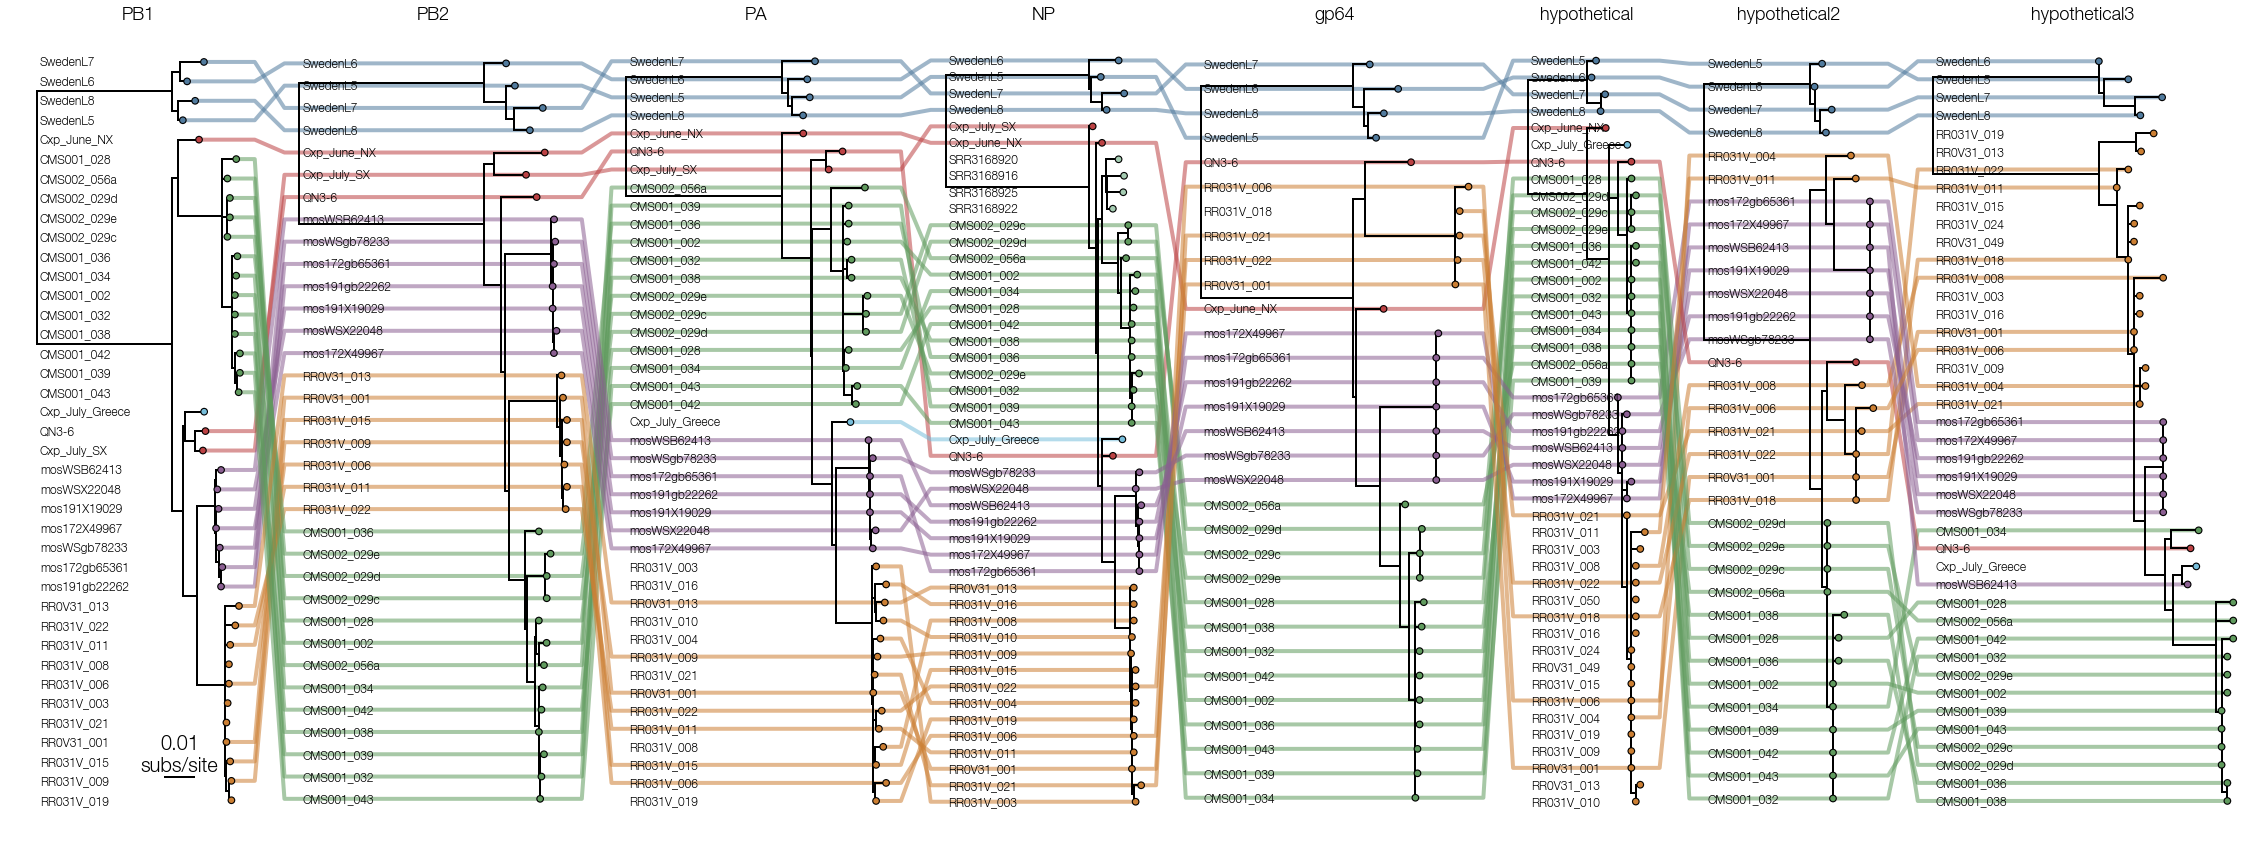

In [8]:
def subplot_tanglegram(ax):
    
    trees={}
    base_path='/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/data/SFig3'
    for tfile in glob.glob(os.path.join(base_path,'*.newick')):
        segment=os.path.basename(tfile).split('.')[0]
        print(segment)
        ll=bt.loadNewick(tfile)
        ll.treeStats()
        ll=ll.collapseBranches(lambda k: k.length==0.0)
        ll=ll.reduceTree([k for k in ll.getExternal() if k.is_leaf() and 'NJ' not in k.name]) ## remove non-public sequences
        ll.sortBranches()
        trees[segment]=ll
    
    order=['PB1','PB2','PA','NP','gp64','hypothetical','hypothetical2','hypothetical3']

    ys={seg: {k.name: k.y for k in trees[seg].getExternal()} for seg in order}
    
    tip_colours={'CHN': '#bc4244', ## Hubei
                 'CHN-NX': '#bc4244', ## Ningxia Hui Autonomous Region
                 'CHN-SX': '#bc4244', ## Shaanxi Province
                 'SWE-Kristianstad': '#517b9e', 
                 'SWE-Dalalven': '#517b9e', 
                 'USA-CA': '#609b5e', 
                 'USA-NJ': '#5e9b9b', 
                 'AUS': '#8b5f92', 
                 'KHM': '#cc7f33', 
                 'GRC': '#77BEDB',
                 'PRI': '#A5CCB2'}
    offset=0
    space=0.02
    
    
    L=0.01
    x=0.043
    y=2
    ax.plot([x,x+L],[y,y],color='k',lw=2)
    ax.text(x+L/2,y+0.1,'%s\nsubs/site'%(L),va='bottom',ha='center',size=20)
    
    for s,seg in enumerate(order):
        ll=trees[seg]
        
        tip_colour=lambda k: tip_colours[k.name.split('|')[2]]

        tallestTree=max([trees[s].ySpan for s in trees])

        x_attr=lambda k: k.x+offset if k.parent else k.x
        y_attr=lambda k: k.y*(tallestTree/ll.ySpan)

        ll.plotTree(ax,x_attr=x_attr,y_attr=y_attr,width=2)
        ll.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size=30,colour=tip_colour)
        
        ll.addText(ax,x_attr=lambda k: offset+0.001,y_attr=y_attr,text=lambda k: k.name.split('|')[0],ha='left',va='center',size=12)
        
        ax.text(offset+ll.treeHeight/2,tallestTree+2,seg,ha='center',size=18)
        if s<len(order)-1:
            for k in ll.getExternal(lambda q: q.name in [w.name for w in trees[order[s+1]].getExternal()]): ## current tree
                x1=x_attr(k)
                x2=max(map(x_attr,ll.getExternal()))+space*0.25

                counterpart=trees[order[s+1]].getBranches(lambda w: w.branchType=='leaf' and w.name==k.name)
                y1=y_attr(k)
                
                y_attr2=lambda q: q.y*(tallestTree/trees[order[s+1]].ySpan)
                y2=y_attr2(counterpart)

                x3=max(map(x_attr,ll.getExternal()))+space*0.75
                x4=max(map(x_attr,ll.getExternal()))+space+counterpart.x

                ax.plot([x1,x2,x3,x4],[y1,y1,y2,y2],color=tip_colour(k),lw=4,alpha=0.55,zorder=0)

        offset+=ll.treeHeight+space

    
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    ax.plot()
    
    ax.set_xlim(-space/2,offset-space*0.9)
    return ax

fig = plt.subplots(figsize=(40,15),facecolor='w')

gs = GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

subplot_tanglegram(ax)

plt.savefig('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/figures/SuppFig3_MLtangle.png',bbox_inches='tight',dpi=300)
plt.savefig('/Users/evogytis/Documents/manuscripts/wuhan6-phylodynamics/figures/SuppFig3_MLtangle.pdf',bbox_inches='tight',dpi=300)

plt.show()